In [229]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pprint

import requests
import json
from difflib import get_close_matches
from difflib import SequenceMatcher

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA

plt.style.use('seaborn')

In [3]:
genres_item_matrix = pd.read_csv('data/genres_item_matrix.csv', index_col='id')
tag_item_matrix = pd.read_csv('data/tag_item_matrix.csv', index_col='id')
tag_rank_item_matrix = pd.read_csv('data/tag_rank_item_matrix.csv', index_col='id')
title_df = pd.read_csv('data/title_df.csv', index_col='id')

In [4]:
# We'll use this dataframe later for lookup
title_df.head()

,romaji,english,native,userPreferred
id,,,,
10161,No.6,No.6,NO.6 ナンバー・シックス,No.6
99726,Net-juu no Susume,Recovery of an MMO Junkie,ネト充のススメ,Net-juu no Susume
98526,Robomasters The Animated Series,NaN,ROBOMASTERS THE ANIMATED SERIES,Robomasters The Animated Series
966,Crayon Shin-chan,Shin Chan,クレヨンしんちゃん,Crayon Shin-chan
4876,Hashire Melos!,Run Melos!,走れメロス,Hashire Melos!


In [5]:
genres_item_matrix.head()

,action,adventure,comedy,drama,ecchi,fantasy,horror,mahou_shoujo,mecha,music,mystery,psychological,romance,sci_fi,slice_of_life,sports,supernatural,thriller
id,,,,,,,,,,,,,,,,,,
10161,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
99726,0,1,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0
98526,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
966,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
4876,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
tag_item_matrix.head()

,4_koma,achronological_order,acting,advertisement,afterlife,age_gap,age_regression,agender,airsoft,aliens,...,witch,work,wrestling,writing,wuxia,yakuza,yandere,youkai,yuri,zombie
id,,,,,,,,,,,,,,,,,,,,,
10161,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
99726,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98526,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
966,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4876,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
df = pd.concat([genres_item_matrix, tag_item_matrix], axis=1)
df.head()

,action,adventure,comedy,drama,ecchi,fantasy,horror,mahou_shoujo,mecha,music,...,witch,work,wrestling,writing,wuxia,yakuza,yandere,youkai,yuri,zombie
id,,,,,,,,,,,,,,,,,,,,,
10161,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
99726,0,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98526,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
966,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4876,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
df.tail()

,action,adventure,comedy,drama,ecchi,fantasy,horror,mahou_shoujo,mecha,music,...,witch,work,wrestling,writing,wuxia,yakuza,yandere,youkai,yuri,zombie
id,,,,,,,,,,,,,,,,,,,,,
99586,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99916,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
101283,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101633,0,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
101089,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9832 entries, 10161 to 101089
Columns: 265 entries, action to zombie
dtypes: int64(265)
memory usage: 20.0 MB


In [10]:
df.describe()

,action,adventure,comedy,drama,ecchi,fantasy,horror,mahou_shoujo,mecha,music,...,witch,work,wrestling,writing,wuxia,yakuza,yandere,youkai,yuri,zombie
count,9832.000000,9832.000000,9832.000000,9832.000000,9832.000000,9832.000000,9832.000000,9832.000000,9832.000000,9832.000000,...,9832.000000,9832.000000,9832.000000,9832.000000,9832.000000,9832.000000,9832.000000,9832.000000,9832.000000,9832.000000
mean,0.268002,0.213283,0.391172,0.190704,0.062449,0.198841,0.034886,0.025325,0.082994,0.097539,...,0.006001,0.018206,0.002034,0.001526,0.000305,0.003458,0.004577,0.011086,0.025427,0.005391
std,0.442941,0.409647,0.488038,0.392876,0.241982,0.399148,0.183501,0.157120,0.275888,0.297048,...,0.077236,0.133702,0.045058,0.039032,0.017466,0.058707,0.067501,0.104711,0.157427,0.073226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
total_per_feature = df.sum(axis=0)
total_per_feature

action       2635
adventure    2097
comedy       3846
drama        1875
ecchi         614
             ... 
yakuza         34
yandere        45
youkai        109
yuri          250
zombie         53
Length: 265, dtype: int64

In [12]:
total_per_show = df.sum(axis=1)
total_per_show

id
10161      9
99726     13
98526      5
966        9
4876      11
          ..
99586     11
99916      7
101283    18
101633    12
101089     3
Length: 9832, dtype: int64

In [13]:
total_per_show.rename('total_features_per_show')

id
10161      9
99726     13
98526      5
966        9
4876      11
          ..
99586     11
99916      7
101283    18
101633    12
101089     3
Name: total_features_per_show, Length: 9832, dtype: int64

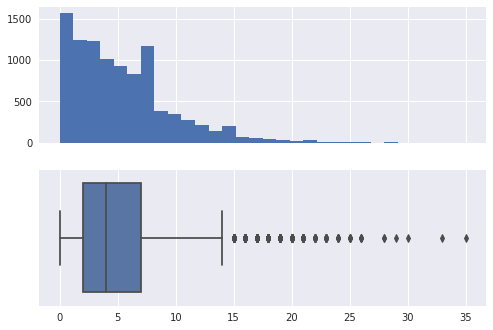

In [14]:
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].hist(total_per_show, bins=30)
ax[1] = sns.boxplot(total_per_show);

This seems potentially problematic. A majority of the shows don't have very many features. How many are needed to make an acurate recommendation?

In [15]:
def count_for_n_features(series, n):
    print('{0:.1%}'.format(len(series[series <= n]) / len(series)), 
          'or', len(series[series <= n]), f'shows have {n} or fewer features describing them.')


In [16]:
count_for_n_features(total_per_show, 2)

28.5% or 2805 shows have 2 or fewer features describing them.


In [17]:
count_for_n_features(total_per_show, 3)

41.0% or 4034 shows have 3 or fewer features describing them.


In [18]:
count_for_n_features(total_per_show, 4)

51.3% or 5047 shows have 4 or fewer features describing them.


While selecting which tags to keep, many were cut out because of a low "rank" score. Let's go back and keep all tags but normalize(standardize?) them. 

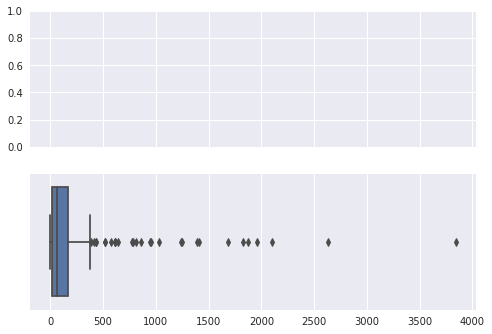

In [21]:
fig, ax = plt.subplots(2,1, sharex=True)
# ax[0].hist(total_per_show, bins=30)
ax[1] = sns.boxplot(total_per_feature);

In [22]:
# the tags below each describe 5 or fewer anime. They can be dropped without losing too much.
total_per_feature[total_per_feature < 6]

airsoft         5
asexual         4
badminton       2
bondage         5
calligraphy     4
centaur         5
cheerleading    5
ero_guro        4
feet            1
full_color      1
go              4
lacrosse        4
masturbation    1
netorare        4
pov             1
prostitution    1
reformation     1
rugby           3
surfing         3
table_tennis    4
teens_love      3
urination       1
vikings         2
voyeur          1
wuxia           3
dtype: int64

## Getting Recommendations

In [23]:
def jaccard_similarity(df):
    return (1 - pairwise_distances(df, metric="jaccard"))


def get_anime_id(search_term):
    id_list = []
    anime_id = title_df[title_df['userPreferred'].isin([search_term])].index
    id_list.append(anime_id)
    
    return id_list[0].values[0]


def get_top_n_recommendations(anime_id, dataframe, similarity_matrix, n=5):
    positional_idx = dataframe.index.get_loc(anime_id)
    
    top_n = np.argsort(similarity_matrix[positional_idx,:])[-n-1:-1]
    recom_titles = []
    for idx, row in title_df.iloc[top_n,:].iterrows():
        if type(row['english']) != float:
            recom_titles.append(row['english'])
        else:
            recom_titles.append(row['userPreferred'])
    
    return recom_titles


def view_title_similarity(search_term, recom_titles):
    for title in recom_titles:
        seq_matcher = SequenceMatcher(None, search_term, title)
        print(f'The terms "{search_term}" and "{title}" are ' 
              + '{0:.2%}'.format(seq_matcher.quick_ratio()) + ' alike.')

In [24]:
cos_sim = cosine_similarity(df.values)

jac_sim = jaccard_similarity(df.values)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1735: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [25]:
def get_search_term(initial_search):
    '''Search the AniList API for a show based on a query.
    
    Returns the user preferred title 
    '''
    query = '''
    query ($search: String) {
      Media (type: ANIME, search: $search) {
        id
        title {
          romaji
          english
          native
          userPreferred
        }
      }
    }
    '''
    variables = {'search': initial_search}

    url = 'https://graphql.anilist.co'
    response = requests.post(url, 
                             json={'query': query, 
                                   'variables': variables})
    user_preferred_title = response.json()['data']['Media']['title']['userPreferred']

    return user_preferred_title

<b>Recommendations should probably exclude titles from the same franchise.  
For example, try getting recommendations for Ghost in the Shell.  
If you already know you like Ghost in the Shell, it's pretty easy to find others in the same franchise if that's what you want.  </b>

First of all, our rudimentary search engine is failing...

In [26]:
initial_search = 'Ghost in the Shell'
search_term = get_search_term(initial_search)
search_term

'Koukaku Kidoutai'

In [27]:
id_list = get_anime_id(search_term)
rec_list = get_top_n_recommendations(id_list, df, cos_sim, n=10)
rec_list

['Ghost in the Shell: Stand Alone Complex - Solid State Society',
 'Harmony',
 'Ghost in the Shell Arise: Alternative Architecture',
 'PSYCHO-PASS Sinners of the System Case 1: Tsumi to Batsu',
 'Ghost in the Shell 2: Innocence',
 'Ghost in the Shell: Stand Alone Complex - The Laughing Man',
 'Ghost in the Shell: Stand Alone Complex 2nd GIG',
 'PSYCHO-PASS 2',
 'Ghost in the Shell: Stand Alone Complex',
 'PSYCHO-PASS']

In [28]:
initial_search = "Wolf's Rain"
search_term = get_search_term(initial_search)
search_term

"Wolf's Rain"

In [29]:
id_list = get_anime_id(search_term)
id_list

202

In [34]:
rec_list = get_top_n_recommendations(id_list, df, cos_sim, n=10)
print('-----')
print(f'Top {5} based on {search_term}: \n{rec_list}')

-----
Top 5 based on Wolf's Rain: 
['COCOLORS', 'Hi no Tori 2772: Ai no CosmoZone', 'AOTU Shijie', 'Planetarian', 'Pokémon: Lucario and the Mystery of Mew', 'Final Fantasy VII: Last Order', 'Mujin Wakusei Survive', 'Texhnolyze', 'Wan Wan Chuushingura', "Wolf's Rain OVA"]


In [35]:
view_title_similarity(search_term, rec_list)

The terms "Wolf's Rain" and "COCOLORS" are 10.53% alike.
The terms "Wolf's Rain" and "Hi no Tori 2772: Ai no CosmoZone" are 23.26% alike.
The terms "Wolf's Rain" and "AOTU Shijie" are 18.18% alike.
The terms "Wolf's Rain" and "Planetarian" are 36.36% alike.
The terms "Wolf's Rain" and "Pokémon: Lucario and the Mystery of Mew" are 28.00% alike.
The terms "Wolf's Rain" and "Final Fantasy VII: Last Order" are 30.00% alike.
The terms "Wolf's Rain" and "Mujin Wakusei Survive" are 37.50% alike.
The terms "Wolf's Rain" and "Texhnolyze" are 28.57% alike.
The terms "Wolf's Rain" and "Wan Wan Chuushingura" are 38.71% alike.
The terms "Wolf's Rain" and "Wolf's Rain OVA" are 84.62% alike.


Why is a Pokemon movie showing up as a recommendation based on Wolf's Rain? Also, why is Wan Wan Chuushingur being recommended. More on that one later. 

## Understanding Bad Recommendations

<tr>
    <td> <img src="https://upload.wikimedia.org/wikipedia/en/thumb/4/43/Wolf%27s_Rain_Region_2_Volume_1.jpg/220px-Wolf%27s_Rain_Region_2_Volume_1.jpg" alt="Drawing" style="width: 250px;"/> </td>
    <td> <img src="https://upload.wikimedia.org/wikipedia/en/thumb/9/95/Pok%C3%A9mon_Lucario_film_poster.jpg/220px-Pok%C3%A9mon_Lucario_film_poster.jpg" alt="Drawing" style="width: 250px;"/> </td>
    </tr>

In [36]:
wr_id = title_df[title_df['english'] == "Wolf's Rain"].index
wr_df = df.loc[wr_id,:]

In [37]:
# Genres and tags for Wolf's Rain
wr_df.loc[:, (wr_df != 0).any(axis=0)]

,action,adventure,drama,fantasy,mystery,sci_fi,animals,dystopian,post_apocalyptic,primarily_adult_cast,survival,tragedy,werewolf
id,,,,,,,,,,,,,
202,1,1,1,1,1,1,1,1,1,1,1,1,1


In [38]:
pk_id = title_df[title_df['english'] == "Pokémon: Lucario and the Mystery of Mew"].index
pk_df = df.loc[pk_id,:]

In [39]:
# Genres and tags for Pokémon: Lucario and the Mystery of Mew
pk_df.loc[:, (pk_df != 0).any(axis=0)]

,action,adventure,drama,fantasy,animals,kids
id,,,,,,
1526,1,1,1,1,1,1


Would it be wise to give a heavier weight to the "kids" column?

In [40]:
sum(df['kids'])

782

In [41]:
total_per_feature['kids']

782

In [42]:
len(df)

9832

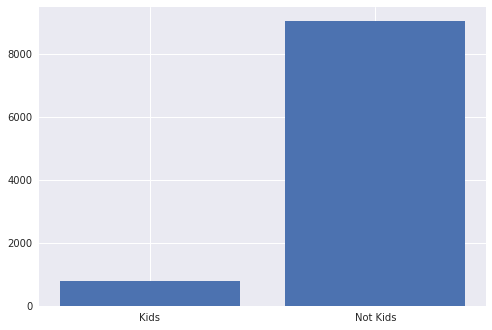

In [43]:
plt.bar(['Kids', 'Not Kids'], [total_per_feature['kids'], len(df) - total_per_feature['kids']]);

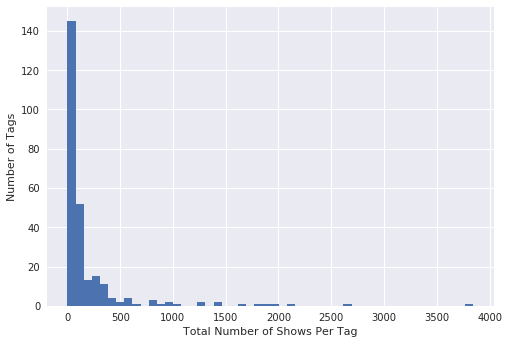

In [44]:
plt.hist(total_per_feature, bins=50)
plt.ylabel('Number of Tags')
plt.xlabel('Total Number of Shows Per Tag');

In [45]:
for tag, count in total_per_feature.sort_values(ascending=False).iteritems():
    print(tag, count)

comedy 3846
action 2635
adventure 2097
fantasy 1955
drama 1875
sci_fi 1830
shounen 1681
romance 1413
school 1390
slice_of_life 1252
male_protagonist 1235
female_protagonist 1031
music 959
supernatural 946
magic 857
mecha 816
kids 782
primarily_female_cast 773
super_power 640
ecchi 614
seinen 612
historical 610
shoujo 576
sports 521
mystery 518
military 438
parody 434
tragedy 411
primarily_adult_cast 386
space 377
demons 370
harem 364
horror 343
primarily_male_cast 340
nudity 338
animals 336
aliens 319
psychological 318
cute_girls_doing_cute_things 313
episodic 310
swordplay 297
henshin 287
ensemble_cast 287
cgi 279
urban_fantasy 270
coming_of_age 269
love_triangle 252
yuri 250
war 249
mahou_shoujo 249
idol 245
robots 244
isekai 243
foreign 240
gore 238
police 207
school_club 203
primarily_child_cast 191
time_manipulation 191
full_cgi 186
guns 181
work 179
post_apocalyptic 172
gods 168
super_robot 167
meta 167
surreal_comedy 166
real_robot 159
martial_arts 152
chibi 148
revenge 147
tsun

<b>Would like to penalize features that describe a large number of shows (i.e. comedy) and give a heavier weight to those that describe fewer shows.  
The normalization should be strong enough to not recommend a Pokemon movie when looking at "Wolf's Rain" but not so strong that all recommendations are based on the rarest tag. </b>

In [46]:
initial_search = 'Ghost in the Shell'
search_term = get_search_term(initial_search)
search_term

'Koukaku Kidoutai'

In [47]:
# using cosine similarity 
id_list = get_anime_id(search_term)
rec_list = get_top_n_recommendations(id_list, df, cos_sim, n=10)
rec_list

['Ghost in the Shell: Stand Alone Complex - Solid State Society',
 'Harmony',
 'Ghost in the Shell Arise: Alternative Architecture',
 'PSYCHO-PASS Sinners of the System Case 1: Tsumi to Batsu',
 'Ghost in the Shell 2: Innocence',
 'Ghost in the Shell: Stand Alone Complex - The Laughing Man',
 'Ghost in the Shell: Stand Alone Complex 2nd GIG',
 'PSYCHO-PASS 2',
 'Ghost in the Shell: Stand Alone Complex',
 'PSYCHO-PASS']

<b> The search is working but maybe we're returning too many from the same franchise.</b>

In [48]:
view_title_similarity('Ghost in the Shell', rec_list)

The terms "Ghost in the Shell" and "Ghost in the Shell: Stand Alone Complex - Solid State Society" are 45.57% alike.
The terms "Ghost in the Shell" and "Harmony" are 16.00% alike.
The terms "Ghost in the Shell" and "Ghost in the Shell Arise: Alternative Architecture" are 52.94% alike.
The terms "Ghost in the Shell" and "PSYCHO-PASS Sinners of the System Case 1: Tsumi to Batsu" are 35.14% alike.
The terms "Ghost in the Shell" and "Ghost in the Shell 2: Innocence" are 73.47% alike.
The terms "Ghost in the Shell" and "Ghost in the Shell: Stand Alone Complex - The Laughing Man" are 47.37% alike.
The terms "Ghost in the Shell" and "Ghost in the Shell: Stand Alone Complex 2nd GIG" are 55.38% alike.
The terms "Ghost in the Shell" and "PSYCHO-PASS 2" are 12.90% alike.
The terms "Ghost in the Shell" and "Ghost in the Shell: Stand Alone Complex" are 63.16% alike.
The terms "Ghost in the Shell" and "PSYCHO-PASS" are 6.90% alike.


In [49]:
seq_matcher = SequenceMatcher(None, 
                              "Ghost in the Shell Arise: Alternative Architecture", 
                              "Ghost in the Shell: Stand Alone Complex 2nd GIG")
seq_matcher.quick_ratio()

0.5979381443298969

This is one problem with the recommender. The recommendations are good but too many are not very useful for a user. Future work on the project would include going through and filtering out titles from the same franchise or only including one title per franchise. 

In [50]:
id_list = get_anime_id(search_term)
rec_list = get_top_n_recommendations(id_list, df, cos_sim, n=25)
rec_list

['Appleseed',
 'New Cutey Honey',
 'Armitage III',
 'Fireball Charming',
 'Jin-Roh: The Wolf Brigade',
 'Psycho-Pass: The Movie',
 'Mardock Scramble: The First Compression',
 'Ergo Proxy',
 'Ghost in the Shell: SAC_2045',
 'The Animatrix',
 'Mardock Scramble: The Second Combustion',
 'Ghost in the Shell: Arise - Border:2 Ghost Whispers',
 'Ghost in the Shell: Arise - Border:3 Ghost Tears',
 'Ghost in the Shell: Arise - Border:1 Ghost Pain',
 'Ghost in the Shell: Arise - Border:4 Ghost Stands Alone',
 'Ghost in the Shell: Stand Alone Complex - Solid State Society',
 'Harmony',
 'Ghost in the Shell Arise: Alternative Architecture',
 'PSYCHO-PASS Sinners of the System Case 1: Tsumi to Batsu',
 'Ghost in the Shell 2: Innocence',
 'Ghost in the Shell: Stand Alone Complex - The Laughing Man',
 'Ghost in the Shell: Stand Alone Complex 2nd GIG',
 'PSYCHO-PASS 2',
 'Ghost in the Shell: Stand Alone Complex',
 'PSYCHO-PASS']

In [51]:
## top 10 while limiting 1 per franchise
['Appleseed',
 'New Cutey Honey',
 'Armitage III',
 'Fireball Charming',
 'Jin-Roh: The Wolf Brigade',
 'Ergo Proxy',
 'The Animatrix',
 'Mardock Scramble: The Second Combustion',
 'Harmony',
 'Ghost in the Shell: Stand Alone Complex',
 'PSYCHO-PASS']

['Appleseed',
 'New Cutey Honey',
 'Armitage III',
 'Fireball Charming',
 'Jin-Roh: The Wolf Brigade',
 'Ergo Proxy',
 'The Animatrix',
 'Mardock Scramble: The Second Combustion',
 'Harmony',
 'Ghost in the Shell: Stand Alone Complex',
 'PSYCHO-PASS']

## Comparing Cosine Similarity and Jaccard

We can do Jaccard because our data is still binary

### Samurai Champloo

In [52]:
initial_search = 'Samurai Champloo'
search_term = get_search_term(initial_search)
search_term

'Samurai Champloo'

In [53]:
id_list = get_anime_id(search_term)
rec_list = get_top_n_recommendations(id_list, df, cos_sim, n=10)
rec_list

['Ranma ½: Nihao My Concubine',
 'Boruto: Jump Festa 2016 Special',
 'Golden Kamuy OVA',
 'Blade of the Immortal',
 "Ranma ½: One Flew Over the Kuno's Nest",
 'Virtua Fighter',
 'Lupin III: The Columbus Files',
 'Time of Shura',
 'Carried by the Wind: Tsukikage Ran',
 'Rurouni Kenshin']

In [54]:
id_list = get_anime_id(search_term)
rec_list = get_top_n_recommendations(id_list, df, jac_sim, n=10)
rec_list

['Boruto: Jump Festa 2016 Special',
 'Boruto: Naruto the Movie',
 'Samurai X Recap',
 'Peacemaker',
 'DRIFTERS OVA',
 'Virtua Fighter',
 'Lupin III: The Columbus Files',
 'Carried by the Wind: Tsukikage Ran',
 'Time of Shura',
 'Rurouni Kenshin']

Cosine similarity and jaccard similarity are returning similar results.

In [55]:
def view_features(search_term, df):
    _id = title_df[title_df['userPreferred'] == search_term].index
    _df = df.loc[_id,:]
    return list(_df.loc[:, (_df != 0).any(axis=0)].columns)

In [56]:
champloo_tags = view_features(get_search_term('Samurai Champloo'), df)
champloo_tags

['action',
 'adventure',
 'comedy',
 'anachronism',
 'baseball',
 'historical',
 'martial_arts',
 'primarily_adult_cast',
 'rural',
 'samurai',
 'shounen',
 'swordplay',
 'yakuza']

In [57]:
# Blade of the Immortal scored higher with cosine similarity than jaccard similarity
blade_immortal_tags = view_features(get_search_term("Blade of the Immortal"), df)
blade_immortal_tags

['action', 'adventure', 'supernatural', 'historical', 'samurai', 'swordplay']

In [58]:
# "Ranma ½: One Flew Over the Kuno's Nest" scored higher with jaccard similarity than cosine similarity
ranma_tags = view_features(get_search_term("Ranma ½: One Flew Over the Kuno's Nest"), df)
ranma_tags

['action', 'adventure', 'comedy', 'supernatural', 'martial_arts', 'shounen']

Both have a "supernatural" tag while "Samurai Champloo" does not.  
"Action" and "Adventure" are present for all three.  
"Blade of the Immortal" shares "historical", "samurai", and "swordplay"  
"Ranma ½: One Flew Over the Kuno's Nest" shares "comedy", "martial_arts", and "shounen".

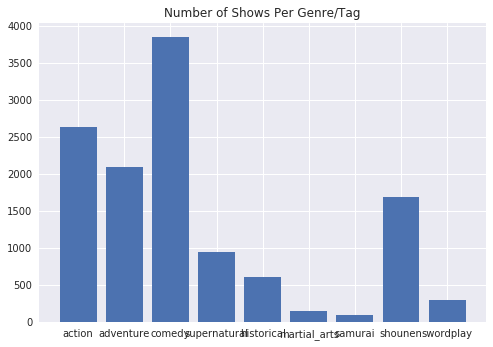

In [59]:
temp_categories = total_per_feature[total_per_feature.index.isin(['action', 
                                                                  'adventure', 
                                                                  'supernatural', 
                                                                  'historical', 
                                                                  'samurai', 
                                                                  'swordplay', 
                                                                  'comedy', 
                                                                  'martial_arts', 
                                                                  'shounen'])]
plt.bar(temp_categories.index, temp_categories)
plt.title('Number of Shows Per Genre/Tag');

Not sure what's going on but it appears jaccard similarity may be favoring more common features.  
To Be Continued...

## Diving into EDA

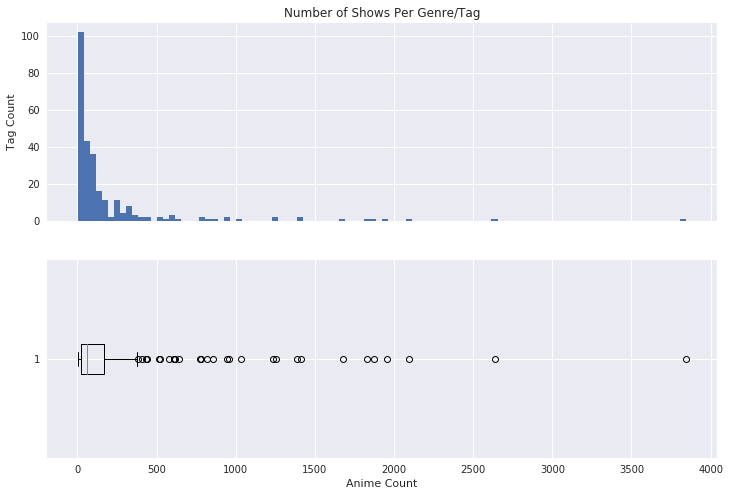

In [60]:
fig, ax = plt.subplots(2, 1, figsize=(12,8), sharex=True)
ax[0].hist(total_per_feature, bins=100)
ax[0].set_title('Number of Shows Per Genre/Tag')
ax[0].set_ylabel('Tag Count')

ax[1].boxplot(total_per_feature, vert=False)
ax[1].set_xlabel('Anime Count');

### Genres

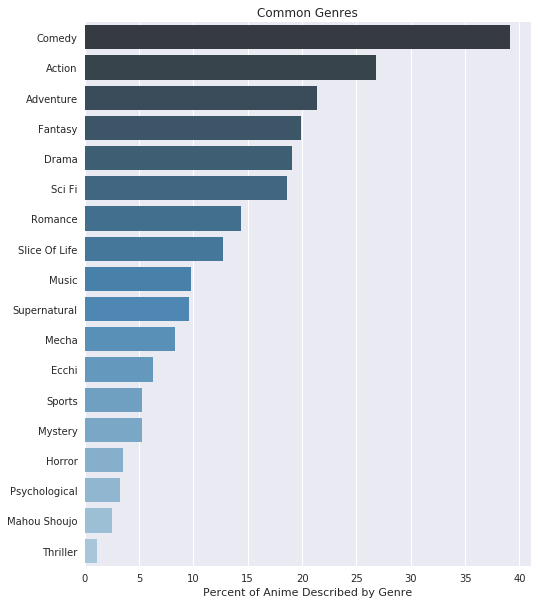

In [61]:
sorted_genres = genres_item_matrix.sum(axis=0).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(8, 10))
ax = sns.barplot([((x/len(df)) * 100) for x in sorted_genres], 
                 [(x.replace('_', ' ')).title() for x in sorted_genres.index], 
                 orient='h', palette='Blues_d')
ax.set_title('Common Genres')
ax.set_xlabel('Percent of Anime Described by Genre');

<b>Slice of Life</b> - depiction of everyday life experiences of (usually) ordinary people

<b>Mecha</b> - giant robots

<b>Ecchi</b> - defined by Wikipedia as "an often used slang term in the Japanese language for playfully sexual actions"

<b>Mahou Shoujo</b> - magical girl


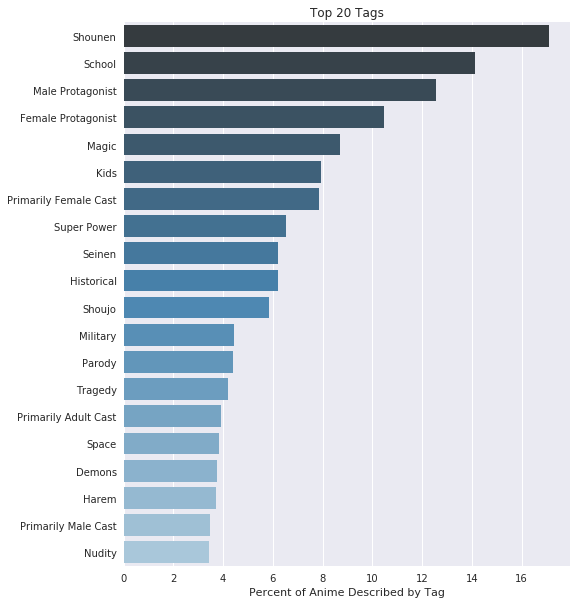

In [62]:
sorted_tags = tag_item_matrix.sum(axis=0).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(8, 10))
count=20
ax = sns.barplot([((x/len(df)) * 100) for x in sorted_tags[:count]], 
                 [(x.replace('_', ' ')).title() for x in sorted_tags.index[:count]], 
                 orient='h', palette='Blues_d')
ax.set_title(f'Top {count} Tags')
ax.set_xlabel('Percent of Anime Described by Tag');

<b>Shounen</b> - manga and anime marketed towards teenage males. 

<b>Seinen</b> - manga and anime marketed towards young adult men.

<b>Shoujo</b> - manga and anime marketed towards teenage females.

## Weighing Features

In [63]:
tag_rank_item_matrix.head()

,4_koma,achronological_order,acting,advertisement,afterlife,age_gap,age_regression,agender,airsoft,aliens,...,witch,work,wrestling,writing,wuxia,yakuza,yandere,youkai,yuri,zombie
id,,,,,,,,,,,,,,,,,,,,,
10161,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.44,0.0,0.0,0.0
99726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
98526,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
966,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
4876,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0


In [64]:
df_w_rank = pd.concat([genres_item_matrix, tag_rank_item_matrix], axis=1)
df_w_rank.head()

,action,adventure,comedy,drama,ecchi,fantasy,horror,mahou_shoujo,mecha,music,...,witch,work,wrestling,writing,wuxia,yakuza,yandere,youkai,yuri,zombie
id,,,,,,,,,,,,,,,,,,,,,
10161,1,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.44,0.0,0.0,0.0
99726,0,1,1,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
98526,1,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
966,0,0,1,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
4876,1,1,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0


In [65]:
cos_sim_rank = cosine_similarity(df_w_rank.values)

In [66]:
rec_list = get_top_n_recommendations(id_list, df, cos_sim, n=5)


In [67]:
# boolean matrix
initial_search = "Wolf's Rain"
search_term = get_search_term(initial_search)

id_list = get_anime_id(search_term)
rec_list = get_top_n_recommendations(id_list, df, cos_sim, n=10)
rec_list

['COCOLORS',
 'Hi no Tori 2772: Ai no CosmoZone',
 'AOTU Shijie',
 'Planetarian',
 'Pokémon: Lucario and the Mystery of Mew',
 'Final Fantasy VII: Last Order',
 'Mujin Wakusei Survive',
 'Texhnolyze',
 'Wan Wan Chuushingura',
 "Wolf's Rain OVA"]

In [68]:
# Accounting for tag relevance to title
initial_search = "Wolf's Rain"
search_term = get_search_term(initial_search)

id_list = get_anime_id(search_term)
rec_list = get_top_n_recommendations(id_list, df_w_rank, cos_sim_rank, n=10)
rec_list

['Ancien to Mahou no Tablet: Mou Hitotsu no Hirune Hime',
 'Shen Qi Huan Qi Tan',
 'Chrome Shelled Regios',
 'Pokémon: Lucario and the Mystery of Mew',
 'Kingsglaive Final Fantasy XV',
 'Wan Wan Chuushingura',
 "Wolf's Rain OVA",
 'Galilei Donna',
 'Jyu-Oh-Sei: Planet of the Beast King',
 'Final Fantasy VII: Last Order']

<b>Using rank pushed the Pokemon recommendation back. That's a good sign.</b>  
'Wan Wan Chuushingura' is still present through. Why?

In [69]:
view_features(get_search_term("Wolf's Rain"), df_w_rank)

['action',
 'adventure',
 'drama',
 'fantasy',
 'mystery',
 'sci_fi',
 'animals',
 'dystopian',
 'post_apocalyptic',
 'primarily_adult_cast',
 'survival',
 'tragedy',
 'werewolf']

In [70]:
view_features(get_search_term('Wan Wan Chuushingura'), df_w_rank)

['action', 'adventure', 'drama', 'fantasy', 'animals']

All of the tags for "Wan Wan Chuushingura" are also tags for "Wolf's Rain" but there are a few missing that are very important. This goes back to a problem noticed earlier. Our data is more sparce than what is ideal. We need more tags for "Wan Wan Chuushingura" for our recommender to see that maybe this isn't a great suggestion based on Wolf's Rain.  
Would it be worth penalizing titles with fewer features?  
Or maybe we just cut out titles with fewer features? 

## PCA

In [106]:
df_w_rank.head()

,action,adventure,comedy,drama,ecchi,fantasy,horror,mahou_shoujo,mecha,music,...,witch,work,wrestling,writing,wuxia,yakuza,yandere,youkai,yuri,zombie
id,,,,,,,,,,,,,,,,,,,,,
10161,1,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.44,0.0,0.0,0.0
99726,0,1,1,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
98526,1,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
966,0,0,1,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
4876,1,1,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0


In [117]:
X = df_w_rank.to_numpy()

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)


pca = PCA()
X_pca = pca.fit_transform(X_scaled)

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [119]:
X_pca.shape

(9832, 265)

In [120]:
pca.explained_variance_

array([3.17095016e-01, 2.47166905e-01, 2.02863028e-01, 1.91723922e-01,
       1.48433829e-01, 1.17438792e-01, 1.06691972e-01, 9.83114242e-02,
       9.54736507e-02, 7.75808751e-02, 6.40900215e-02, 6.12821139e-02,
       5.64178294e-02, 5.40338440e-02, 5.14370504e-02, 4.03808359e-02,
       3.55294375e-02, 3.53376712e-02, 3.20539640e-02, 3.01383478e-02,
       2.66751161e-02, 2.38998955e-02, 2.35775430e-02, 2.22208530e-02,
       2.19604131e-02, 1.90672938e-02, 1.88779496e-02, 1.78655849e-02,
       1.74777503e-02, 1.55938685e-02, 1.46738465e-02, 1.35896401e-02,
       1.31059423e-02, 1.26822374e-02, 1.25171492e-02, 1.16817410e-02,
       1.12066450e-02, 1.10876007e-02, 1.08835536e-02, 1.05155569e-02,
       1.00501101e-02, 9.74656662e-03, 9.47270837e-03, 9.12001584e-03,
       9.09539553e-03, 8.90343854e-03, 8.72861873e-03, 8.60096311e-03,
       8.27966499e-03, 8.10657515e-03, 7.89897726e-03, 7.73617356e-03,
       7.63102871e-03, 7.57948223e-03, 7.22636500e-03, 7.04736621e-03,
      

### Selecting N-Components

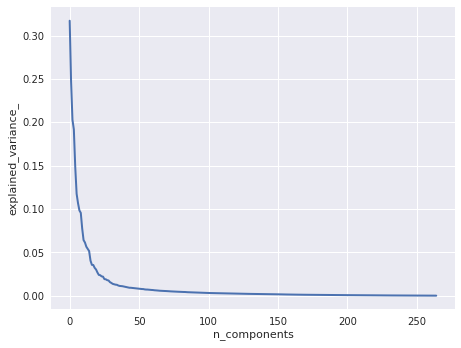

In [121]:
plt.figure(1, figsize=(8, 6))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_');

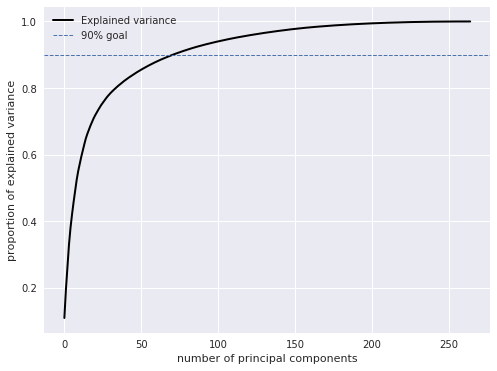

In [122]:
total_variance = np.sum(pca.explained_variance_)
cum_variance = np.cumsum(pca.explained_variance_)
prop_var_expl = cum_variance/total_variance

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(prop_var_expl, color = 'black', linewidth=2, label='Explained variance')
ax.axhline(0.9, label='90% goal', linestyle='--', linewidth=1)
ax.set_ylabel('proportion of explained variance')
ax.set_xlabel('number of principal components')
ax.legend();

In [131]:
len(prop_var_expl[prop_var_expl <= 0.9])

71

In [123]:
df_rank_pca = pd.DataFrame(X_pca, index=df_w_rank.index)
df_rank_pca

,0,1,2,3,4,5,6,7,8,9,...,255,256,257,258,259,260,261,262,263,264
id,,,,,,,,,,,,,,,,,,,,,
10161,0.902054,-0.308564,0.735503,0.421122,0.017534,0.030490,0.243384,0.231923,-0.359571,0.040509,...,-0.002120,0.000602,-0.010317,0.001093,-0.000096,0.000748,0.000421,0.000703,-0.000600,-0.000262
99726,-0.553772,0.919423,-0.563405,0.693138,0.492470,0.506488,0.254710,-0.667565,0.478517,0.084262,...,0.009360,0.000160,0.001203,-0.000147,-0.000960,0.000248,0.000067,0.000446,-0.000009,0.001680
98526,0.562031,-0.360142,0.285042,0.437012,-0.341345,-0.349306,0.202698,0.012140,-0.634208,-0.074446,...,0.000259,0.000007,-0.001400,0.000135,-0.002031,0.001249,0.000173,-0.000885,-0.000042,0.000494
966,-0.947915,0.433247,0.318086,-0.000632,-0.138365,-0.067705,0.449668,-0.391173,0.295403,-0.160394,...,-0.001041,-0.001971,0.000039,0.000592,0.000103,0.000003,-0.000538,-0.000701,0.000221,-0.000599
4876,0.893532,0.062809,-0.076532,0.672134,0.141467,-0.872544,0.062129,-0.331749,-0.450992,0.038072,...,-0.001440,-0.000439,-0.003752,0.000145,0.000479,0.001264,-0.000703,-0.000054,-0.000106,0.000140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99586,-0.492690,-0.461529,0.077596,0.035290,-0.218350,0.116027,0.676679,-0.626119,0.378083,-0.271106,...,-0.001545,0.000331,0.001330,0.000739,-0.004231,0.000167,0.000411,0.000206,0.000138,-0.000998
99916,-0.610720,-0.477351,0.175739,0.605864,-0.083200,0.536619,0.216233,-1.029686,0.625074,-0.133925,...,-0.003522,0.000135,-0.001321,0.000334,-0.000161,-0.002245,0.000456,-0.000029,0.000046,-0.000667
101283,0.072873,-0.510824,-0.055954,0.054418,-0.351963,-0.368537,-0.174322,0.523298,0.773766,0.113511,...,-0.002044,0.001325,-0.003932,-0.000675,0.000201,-0.001402,-0.000088,0.000206,-0.000030,0.000939


In [142]:
sim_mat = cosine_similarity(df_rank_pca.values)

In [143]:
# No PCA
search_term = get_search_term('Cowboy Bebop')
id_list = get_anime_id(search_term)
rec_list = get_top_n_recommendations(id_list, 
                                     df_w_rank, 
                                     cos_sim_rank, 
                                     n=10)
rec_list

['Lost Universe',
 'Lupin the 3rd Part IV',
 'Moonlight Mile',
 "Lupin the IIIrd: Jigen's Gravestone",
 'R.O.D -THE TV-',
 'Dirty Pair OVA',
 'DNA Sights 999.9',
 "Cowboy Bebop: The Movie - Knockin' on Heaven's Door",
 'Outlaw Star',
 'Trigun']

In [144]:
# PCA with all the components
search_term = get_search_term('Cowboy Bebop')
id_list = get_anime_id(search_term)
rec_list = get_top_n_recommendations(id_list, 
                                     df_rank_pca, 
                                     sim_mat, 
                                     n=10)
rec_list

['Captain Harlock: Arcadia of my Youth',
 'R.O.D -THE TV-',
 'Captain Harlock: Arcadia of my Youth - Endless Orbit SSX',
 'DNA Sights 999.9',
 'Dirty Pair OVA',
 'Marine Express',
 'Outlaw Star',
 "Cowboy Bebop: The Movie - Knockin' on Heaven's Door",
 'Lupin the 3rd Part IV',
 'Trigun']

In [134]:
X = df_w_rank.to_numpy()

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)


pca = PCA(n_components=71)
X_pca_71pc = pca.fit_transform(X_scaled)

In [139]:
df_rank_pca_71pc = pd.DataFrame(X_pca_71pc, index=df_w_rank.index)
df_rank_pca_71pc

,0,1,2,3,4,5,6,7,8,9,...,61,62,63,64,65,66,67,68,69,70
id,,,,,,,,,,,,,,,,,,,,,
10161,0.902054,-0.308564,0.735503,0.421122,0.017534,0.030490,0.243382,0.231923,-0.359572,0.040511,...,-0.041002,0.035092,0.030934,0.022348,0.040976,0.021933,0.038171,-0.114028,-0.221647,-0.146414
99726,-0.553772,0.919423,-0.563405,0.693138,0.492470,0.506488,0.254710,-0.667565,0.478517,0.084261,...,0.021061,-0.118325,0.199742,0.283988,-0.008952,-0.274321,0.064231,0.724446,0.021600,0.268293
98526,0.562031,-0.360142,0.285042,0.437012,-0.341345,-0.349306,0.202698,0.012140,-0.634209,-0.074447,...,0.051109,0.116330,-0.004662,0.008003,-0.024439,-0.001991,-0.115709,-0.091548,0.028452,-0.161692
966,-0.947915,0.433247,0.318086,-0.000632,-0.138365,-0.067706,0.449668,-0.391173,0.295402,-0.160396,...,0.019706,-0.141096,-0.080973,0.242295,0.263775,-0.029023,-0.213606,-0.069766,-0.157100,-0.040459
4876,0.893532,0.062809,-0.076532,0.672134,0.141467,-0.872545,0.062129,-0.331749,-0.450991,0.038072,...,0.107628,0.090728,0.033681,-0.180100,-0.084143,-0.157611,0.150025,-0.048111,-0.026437,0.139320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99586,-0.492690,-0.461529,0.077596,0.035290,-0.218350,0.116027,0.676679,-0.626119,0.378083,-0.271106,...,-0.110614,-0.048049,-0.166500,0.031406,-0.028892,-0.105340,-0.038454,0.057020,-0.036150,0.021367
99916,-0.610720,-0.477351,0.175739,0.605864,-0.083200,0.536619,0.216233,-1.029686,0.625074,-0.133926,...,-0.158587,-0.014500,0.137822,0.157178,-0.248783,0.199527,0.045881,0.086861,0.089294,0.076957
101283,0.072873,-0.510824,-0.055954,0.054418,-0.351963,-0.368537,-0.174322,0.523298,0.773766,0.113512,...,-0.127620,-0.255017,0.156741,-0.024764,0.271427,0.058090,0.227632,0.110440,-0.021084,-0.358833


In [140]:
sim_mat_71pc = cosine_similarity(df_rank_pca_71pc.values)

In [145]:
# PCA with 71 components
search_term = get_search_term('Cowboy Bebop')
id_list = get_anime_id(search_term)
rec_list = get_top_n_recommendations(id_list, 
                                     df_rank_pca_71pc, 
                                     sim_mat_71pc, 
                                     n=10)
rec_list

['Captain Harlock: Arcadia of my Youth',
 'R.O.D -THE TV-',
 'Captain Harlock: Arcadia of my Youth - Endless Orbit SSX',
 'DNA Sights 999.9',
 'Dirty Pair OVA',
 'Marine Express',
 'Outlaw Star',
 "Cowboy Bebop: The Movie - Knockin' on Heaven's Door",
 'Lupin the 3rd Part IV',
 'Trigun']

In [146]:
df_rank_pca_71pc.head()

,0,1,2,3,4,5,6,7,8,9,...,61,62,63,64,65,66,67,68,69,70
id,,,,,,,,,,,,,,,,,,,,,
10161,0.902054,-0.308564,0.735503,0.421122,0.017534,0.030490,0.243382,0.231923,-0.359572,0.040511,...,-0.041002,0.035092,0.030934,0.022348,0.040976,0.021933,0.038171,-0.114028,-0.221647,-0.146414
99726,-0.553772,0.919423,-0.563405,0.693138,0.492470,0.506488,0.254710,-0.667565,0.478517,0.084261,...,0.021061,-0.118325,0.199742,0.283988,-0.008952,-0.274321,0.064231,0.724446,0.021600,0.268293
98526,0.562031,-0.360142,0.285042,0.437012,-0.341345,-0.349306,0.202698,0.012140,-0.634209,-0.074447,...,0.051109,0.116330,-0.004662,0.008003,-0.024439,-0.001991,-0.115709,-0.091548,0.028452,-0.161692
966,-0.947915,0.433247,0.318086,-0.000632,-0.138365,-0.067706,0.449668,-0.391173,0.295402,-0.160396,...,0.019706,-0.141096,-0.080973,0.242295,0.263775,-0.029023,-0.213606,-0.069766,-0.157100,-0.040459
4876,0.893532,0.062809,-0.076532,0.672134,0.141467,-0.872545,0.062129,-0.331749,-0.450991,0.038072,...,0.107628,0.090728,0.033681,-0.180100,-0.084143,-0.157611,0.150025,-0.048111,-0.026437,0.139320


In [217]:
def get_title_from_id(_id):
    '''Searches the title dataframe based on an anime id and tries to return the english title. 
    If an english title is not available, the "user preferred" is give. '''
    title = None
    if pd.isna(title_df.loc[title_df.index == _id, 'english']).values[0]:
        title = title_df.loc[title_df.index == _id, 'userPreferred'].values[0]
    else:
        title = title_df.loc[title_df.index == _id, 'english'].values[0]
    
    return title



In [234]:
pp = pprint.PrettyPrinter()
# getting the top 3 titles associated with the first 10 principal components
for pc, content in df_rank_pca_71pc.iloc[:,:10].items():
    print(f'Principal Component {pc}:')
    pp.pprint([get_title_from_id(_id) for _id in content.sort_values(ascending=False)[:10].index])
    print('-----')

Principal Component 0:
['Mobile Suit Gundam Wing',
 'Napping Princess',
 'Melody of Oblivion',
 'Mobile Suit Gundam I',
 "Dragon's Heaven",
 'Yamato Takeru',
 'A Wind Named Amnesia',
 'Digimon X-Evolution',
 'Leda: The Fantastic Adventure of Yohko',
 'Yamato Takeru: After War']
-----
Principal Component 1:
['The Seven Deadly Sins',
 'The Familiar of Zero',
 'Dragon Ball Z Movie: Battle of Gods',
 'Fairy Tail Final Season',
 "Dragon Ball Z Movie: Resurrection 'F'",
 'Is It Wrong to Try to Pick Up Girls in a Dungeon?',
 'Fairy Tail (2014)',
 'Dragon Ball Z: Broly - Second Coming',
 'Black Clover',
 'Fairy Tail']
-----
Principal Component 2:
['Gurren Lagann',
 'DARLING in the FRANXX',
 'Infinite Stratos',
 'Infinite Stratos 2',
 'Gunbuster',
 'IS: Infinite Stratos 2 - Hitonatsu no Omoide',
 'Martian Successor Nadesico: The Prince of Darkness',
 'Martian Successor Nadesico',
 'Armored Trooper Votoms',
 'Macross']
-----
Principal Component 3:
['Revolutionary Girl Utena',
 "Beyond the Bounda

PC0: Mecha
PC1: Action, Adventure, Comedy, Magic, Shounen
PC2: Action, Sci-fy, Comedy, Mecha
